## Vision Transformers for Birds classification

In this notebook, we are going to make use of the Vision Transformers architecture [[1]](http://arxiv.org/abs/2010.11929) to perform image classification.  Since the Transformers models are known to have very large number of parameters compared to more "inductive biased" models such as CNNs, we will use transfert learning from a pretrained model hosted in the HuggingFace Hub to perform classification on our dataset. Note that, if we compare it to the novel huge datasets on which Transformers are trained, our dataset turns out to be very small. It is very unlikely to get fair results with Transformers by training the model from scratch. In fact, the Vision Transformer (ViT) model was pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224, and fine-tuned on ImageNet 2012 (1 million images, 1,000 classes) at resolution 384x384. We will finetune this model on our data by adding a classification head to the Vision Transformers' encoders. 


In [1]:
! pip install -q datasets transformers

## Loading the dataset 

We start by loading our Birds dataset.



In [2]:
!wget -c https://www.di.ens.fr/willow/teaching/recvis18orig/assignment3/bird_dataset.zip -O bird_dataset.zip
!unzip -qq bird_dataset.zip
!rm bird_dataset.zip
!rm -rf __MACOSX/

--2022-11-29 17:31:45--  https://www.di.ens.fr/willow/teaching/recvis18orig/assignment3/bird_dataset.zip
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘bird_dataset.zip’

bird_dataset.zip        [              <=>   ] 183.48M  18.4MB/s    in 11s     

2022-11-29 17:31:58 (17.2 MB/s) - ‘bird_dataset.zip’ saved [192388716]



In [3]:
!mv bird_dataset/train_images/ bird_dataset/train
!mv bird_dataset/val_images/ bird_dataset/val
!rm -r bird_dataset/test_images

In [4]:
from datasets import load_dataset

data_folder = '/kaggle/input/mva-recvis-2022/bird_dataset/'

# load the train dataset 
train_dataset = load_dataset("imagefolder", data_dir=data_folder+'train_images')
# remove a gray image in the dataset 
train_dataset = train_dataset['train'].filter(lambda example, idx: idx != 69, with_indices=True)

# load the validation dataset
val_dataset = load_dataset("imagefolder", data_dir=data_folder+'val_images')['train']
val_dataset

Resolving data files:   0%|          | 0/1082 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset image_folder downloaded and prepared to /root/.cache/huggingface/datasets/image_folder/default-cc89093c5b9b1f9e/0.0.0/ee92df8e96c6907f3c851a987be3fd03d4b93b247e727b69a8e23ac94392a091. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Resolving data files:   0%|          | 0/103 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset image_folder downloaded and prepared to /root/.cache/huggingface/datasets/image_folder/default-171dd4481732a09d/0.0.0/ee92df8e96c6907f3c851a987be3fd03d4b93b247e727b69a8e23ac94392a091. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 103
})

Let's take a look at an image example from the training dataset. 

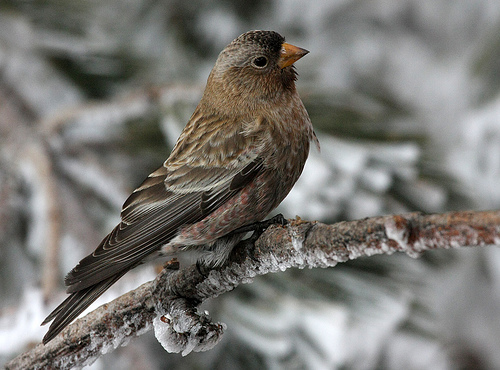

In [5]:
image = train_dataset[-1]['image']
image

The labels in the training dataset can be accessed as follows: 

In [6]:
labels = train_dataset.features['label']
labels

ClassLabel(num_classes=20, names=['004.Groove_billed_Ani', '009.Brewer_Blackbird', '010.Red_winged_Blackbird', '011.Rusty_Blackbird', '012.Yellow_headed_Blackbird', '013.Bobolink', '014.Indigo_Bunting', '015.Lazuli_Bunting', '016.Painted_Bunting', '019.Gray_Catbird', '020.Yellow_breasted_Chat', '021.Eastern_Towhee', '023.Brandt_Cormorant', '026.Bronzed_Cowbird', '028.Brown_Creeper', '029.American_Crow', '030.Fish_Crow', '031.Black_billed_Cuckoo', '033.Yellow_billed_Cuckoo', '034.Gray_crowned_Rosy_Finch'], id=None)

Now, lets print out the class label for our example. 

In [7]:
labels.int2str(train_dataset[-1]['label'])

'034.Gray_crowned_Rosy_Finch'

## Loading ViT Feature Extractor

Now, we will load the ViT Feature Extractor which is simply the image preprocessor of the ViT model. It specifies the specific transforms that should be performed on the images before feeding them to the model. 

In [8]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

If we print a feature extractor, we can see its configuration.

In [9]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

Let's see perform transforms on our image example.


In [10]:
feature_extractor(image, return_tensors='pt')

{'pixel_values': tensor([[[[-0.5608, -0.6078, -0.6078,  ...,  0.3176,  0.3098,  0.3176],
          [-0.5843, -0.5843, -0.6157,  ...,  0.2941,  0.3020,  0.3020],
          [-0.5686, -0.5686, -0.5922,  ...,  0.3176,  0.3098,  0.3020],
          ...,
          [ 0.1529,  0.0980,  0.0510,  ..., -0.0667, -0.0118,  0.0353],
          [ 0.1216,  0.0824, -0.1373,  ..., -0.1059, -0.0667, -0.0196],
          [ 0.1686,  0.1137, -0.2000,  ..., -0.1608, -0.0980, -0.0510]],

         [[-0.5608, -0.5843, -0.5922,  ...,  0.3333,  0.3333,  0.3333],
          [-0.5686, -0.5686, -0.6000,  ...,  0.3333,  0.3333,  0.3176],
          [-0.5373, -0.5529, -0.5686,  ...,  0.3412,  0.3412,  0.3255],
          ...,
          [ 0.1608,  0.0980, -0.0118,  ..., -0.0667, -0.0118,  0.0275],
          [ 0.1216,  0.0745, -0.1922,  ..., -0.1137, -0.0588, -0.0196],
          [ 0.1608,  0.1059, -0.2235,  ..., -0.1686, -0.1059, -0.0588]],

         [[-0.6627, -0.7020, -0.6941,  ...,  0.3569,  0.3569,  0.3569],
          [-0

## Processing the Dataset

Now that we know how to read in images and transform them into inputs, let's write a function that will put those two things together to process a single example from the dataset.

In [11]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['label'] = example['label']
    return inputs

The following function expects a batch of data and performs feature_extractor transforms on it.

In [12]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Include the labels!
    inputs['label'] = example_batch['label']
    return inputs

prepared_train_dataset = train_dataset.with_transform(transform)
prepared_val_dataset = val_dataset.with_transform(transform)

# Training and Evaluation

### Define a data collator

Batches are coming in as lists of dicts, so we just unpack + stack those into batch tensors. We'll not be using dataloaders, as we are going to use HuggingFace's Trainer API.

In [13]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

### Define an evaluation metric

In [14]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions[0], axis=1) # when output_attentions=True
    return metric.compute(predictions=predictions, references=labels)

Now we can load our pretrained model. We'll add `num_labels` on init to make sure the model creates a classification head with the right number of units. We'll also include the `id2label` and `label2id` mappings so we have human readable labels.model_name_or_path

In [17]:
model_name_or_path

'google/vit-base-patch16-224-in21k'

In [15]:
from transformers import ViTForImageClassification

labels = train_dataset.features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    output_attentions=True,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)} 
)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
sum(p.numel() for p in model.parameters())

85814036

Now let's define the training configuration.

In [63]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-birds",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=4,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

PyTorch: setting up devices


In [65]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./vit-base-birds",  
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5, #2e-4
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    report_to='tensorboard',
    remove_unused_columns=False,
)

PyTorch: setting up devices


Now, we are ready to start the training.



In [66]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train_dataset,
    eval_dataset=prepared_val_dataset,
    tokenizer=feature_extractor,
)

In [67]:
# Start tensorboard.
#%load_ext tensorboard
#%tensorboard --logdir logs/

### Training

In [68]:
train_results = trainer.train()
trainer.save_model()
#trainer.log_metrics("train", train_results.metrics)
#trainer.save_metrics("train", train_results.metrics)
#trainer.save_state()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1081
  Num Epochs = 4
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 20
  Gradient Accumulation steps = 1
  Total optimization steps = 220
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.087157,0.864078
2,No log,1.874160,0.873786
3,No log,1.754558,0.883495
4,No log,1.714498,0.864078


***** Running Evaluation *****
  Num examples = 103
  Batch size = 8
Saving model checkpoint to ./vit-base-birds/checkpoint-55
Configuration saved in ./vit-base-birds/checkpoint-55/config.json
Model weights saved in ./vit-base-birds/checkpoint-55/pytorch_model.bin
Feature extractor saved in ./vit-base-birds/checkpoint-55/preprocessor_config.json
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 103
  Batch size = 8
Saving model checkpoint to ./vit-base-birds/checkpoint-110
Configuration saved in ./vit-base-birds/checkpoint-110/config.json
Model weights saved in ./vit-base-birds/checkpoint-110/pytorch_model.bin
Feature extractor saved in ./vit-base-birds/checkpoint-110/preprocessor_config.json
/opt/conda/lib/python3.7/si

### Evaluating

In [69]:
metrics = trainer.evaluate(prepared_val_dataset)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 103
  Batch size = 8
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.8641
  eval_loss               =     1.7145
  eval_runtime            = 0:00:04.52
  eval_samples_per_second =     22.771
  eval_steps_per_second   =      2.874


### Predictions on the entire test dataset

Now that we successfuly trained and saved our model, let's reload it and infer classes on the test dataset.

In [70]:
from transformers import ViTForImageClassification, ViTFeatureExtractor

# import our fine-tuned model
fine_tuned_model_name_or_path = 'vit-base-birds'
model_finetuned = ViTForImageClassification.from_pretrained(fine_tuned_model_name_or_path)
# import features
feature_extractor_finetuned = ViTFeatureExtractor.from_pretrained(fine_tuned_model_name_or_path)

loading configuration file vit-base-birds/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "004.Groove_billed_Ani",
    "1": "009.Brewer_Blackbird",
    "2": "010.Red_winged_Blackbird",
    "3": "011.Rusty_Blackbird",
    "4": "012.Yellow_headed_Blackbird",
    "5": "013.Bobolink",
    "6": "014.Indigo_Bunting",
    "7": "015.Lazuli_Bunting",
    "8": "016.Painted_Bunting",
    "9": "019.Gray_Catbird",
    "10": "020.Yellow_breasted_Chat",
    "11": "021.Eastern_Towhee",
    "12": "023.Brandt_Cormorant",
    "13": "026.Bronzed_Cowbird",
    "14": "028.Brown_Creeper",
    "15": "029.American_Crow",
    "16": "030.Fish_Crow",
    "17": "031.Black_billed_Cuckoo",
    "18": "033.Yellow_billed_Cuckoo",
    "19": "034.Gray_crowned

In [38]:
import PIL.Image as Image
from tqdm import tqdm
import os

test_dir = '/kaggle/input/mva-recvis-2022/bird_dataset/test_images/mistery_category'

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

In [115]:
def predict_testset(model, feature_extractor_finetuned):
    
    test_dir = '/kaggle/input/mva-recvis-2022/bird_dataset/test_images/mistery_category'
    outfile = 'kaggle.csv'
    output_file = open(outfile, "w")
    output_file.write("Id,Category\n")

    for f in tqdm(os.listdir(test_dir)):
        if 'jpg' in f:
            inputs = feature_extractor(pil_loader(test_dir + '/' + f), return_tensors="pt")
            with torch.no_grad():
                logits = model(**inputs).logits
                predicted_label = logits.argmax(-1).item()
            output_file.write("%s,%d\n" % (f[:-4], predicted_label))

    output_file.close()

    print("Succesfully wrote " + outfile + ', you can upload this file to the kaggle competition website')
    
predict_testset(model_finetuned, feature_extractor_finetuned)

100%|██████████| 517/517 [03:42<00:00,  2.33it/s]

Succesfully wrote kaggle.csv, you can upload this file to the kaggle competition website


# Visualizing the attentions

In this section, we are interested in visualizing the attention matrix row belonging to the classification token [CLS], i.e, the dot product of the [CLS] with each of the other 14x14 tokens. This way, we would get an information about each part of the image (patch) the network is focusing on. We will first take the class token's attention matrix row, then we will reshape it to size (224,224) and then we will plot it as a signle channel image.

Let's first import the finetuned model

In [71]:
from transformers import ViTForImageClassification, ViTFeatureExtractor

# import our fine-tuned model
fine_tuned_model_name_or_path = 'vit-base-birds'
model_finetuned = ViTForImageClassification.from_pretrained(fine_tuned_model_name_or_path)
# import features
feature_extractor_finetuned = ViTFeatureExtractor.from_pretrained(fine_tuned_model_name_or_path)

loading configuration file vit-base-birds/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "004.Groove_billed_Ani",
    "1": "009.Brewer_Blackbird",
    "2": "010.Red_winged_Blackbird",
    "3": "011.Rusty_Blackbird",
    "4": "012.Yellow_headed_Blackbird",
    "5": "013.Bobolink",
    "6": "014.Indigo_Bunting",
    "7": "015.Lazuli_Bunting",
    "8": "016.Painted_Bunting",
    "9": "019.Gray_Catbird",
    "10": "020.Yellow_breasted_Chat",
    "11": "021.Eastern_Towhee",
    "12": "023.Brandt_Cormorant",
    "13": "026.Bronzed_Cowbird",
    "14": "028.Brown_Creeper",
    "15": "029.American_Crow",
    "16": "030.Fish_Crow",
    "17": "031.Black_billed_Cuckoo",
    "18": "033.Yellow_billed_Cuckoo",
    "19": "034.Gray_crowned

In [72]:
def predict_class(image, model, actual_label=None, labels= train_dataset.features['label']):
    """ Predicting the class of an input image
    """
    inputs = feature_extractor_finetuned(image, return_tensors="pt")
    logits = model_finetuned(**inputs).logits
    predicted_label = logits.argmax(-1).item()
    label = labels.names[predicted_label]

    display(image)
    if actual_label != None:
        print("The actual label of this image is ", labels.names[actual_label])
    print("The predicted label of this example is", labels.names[predicted_label])
    return model_finetuned(**inputs)

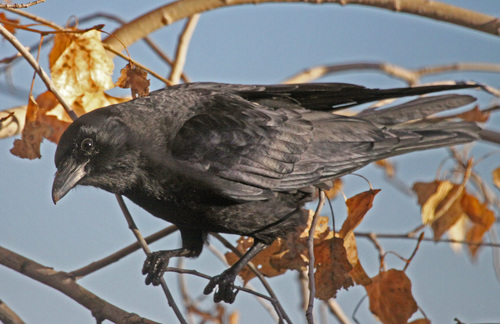

The predicted label of this example is 029.American_Crow


In [73]:
f = '1e2903be123e2e0b747943f46d31113d.jpg'
example = pil_loader(test_dir + '/' + f)
output = predict_class(example, model_finetuned)

In [74]:
# adapted from :
# https://github.com/EscVM/EscVM_YT/blob/master/Notebooks/2%20-%20PT1.X%20DeepAI-Quickie/utils/preprocess.py

from torchvision import transforms
from torch import nn
import matplotlib.pyplot as plt

def transform(img, img_size):
    img = transforms.Resize(img_size)(img)
    img = transforms.ToTensor()(img)
    return img

def visualize_predict(output, img, img_size, patch_size):
    img_pre = transform(img, img_size)
    attention = visualize_attention(output, img_pre, patch_size) 
    plot_attention(img, attention)


def visualize_attention(output, img, patch_size):
    print(img.size())
    # make the image divisible by the patch size
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    attentions = output.attentions[-1]

    nh = attentions.shape[1] # number of head

    # keep only the output patch attention
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)


    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].detach().numpy()

    return attentions

def plot_attention(img, attention):
    n_heads = attention.shape[0]

    plt.figure(figsize=(10,10))
    text = ["Original Image", "Head Mean"]
    for i, fig in enumerate([img, np.mean(attention, 0)]):
        plt.subplot(1, 2, i+1)
        plt.imshow(fig, cmap='inferno')
        plt.title(text[i])
    plt.show()

    plt.figure(figsize=(10,10))    
    for i in range(n_heads):
        plt.subplot(n_heads//3,3, i+1)
        plt.imshow(attention[i], cmap='inferno')
        plt.title(f"Head n: {i+1}")
    plt.tight_layout()
    plt.show()


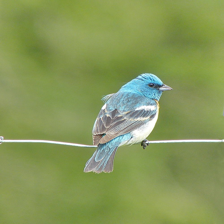

The predicted label of this example is 015.Lazuli_Bunting
torch.Size([3, 224, 224])


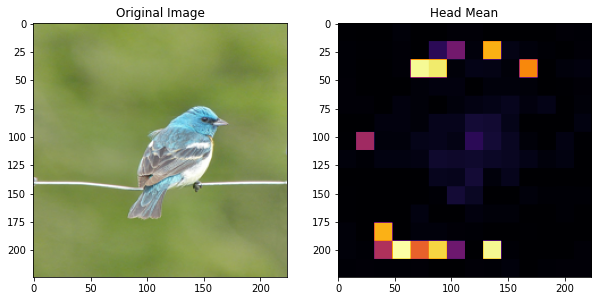

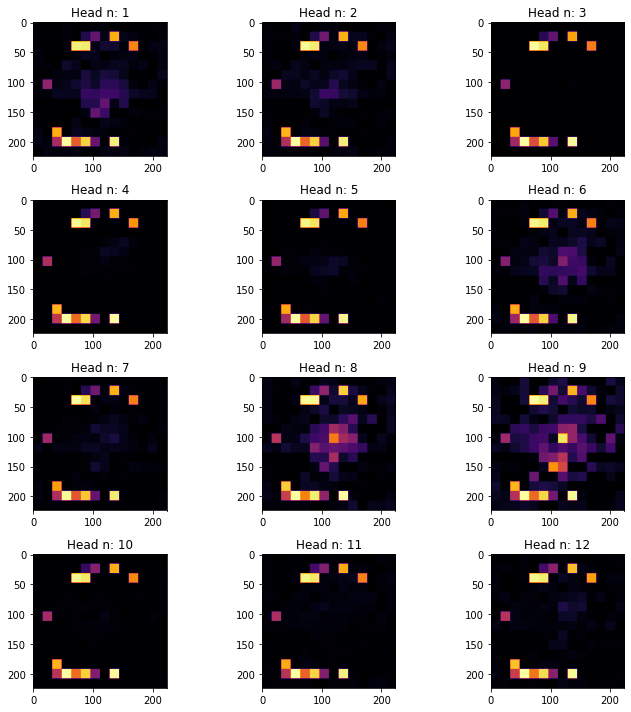

In [85]:
test_dir = '/kaggle/input/mva-recvis-2022/bird_dataset/test_images/mistery_category'
f = '4d6af158889147d8cc51315b59831197.jpg' # loaded image from the test set
img = pil_loader(test_dir + '/' + f)
img = img.resize((224,224))
output = predict_class(img, model_finetuned)
visualize_predict(output, img, img.size, patch_size=16)

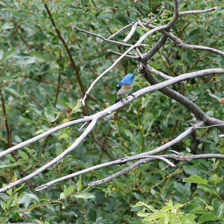

The predicted label of this example is 014.Indigo_Bunting
torch.Size([3, 224, 224])


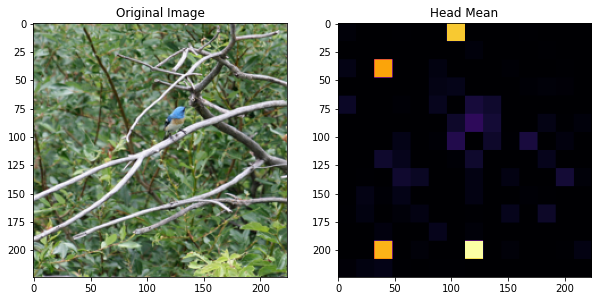

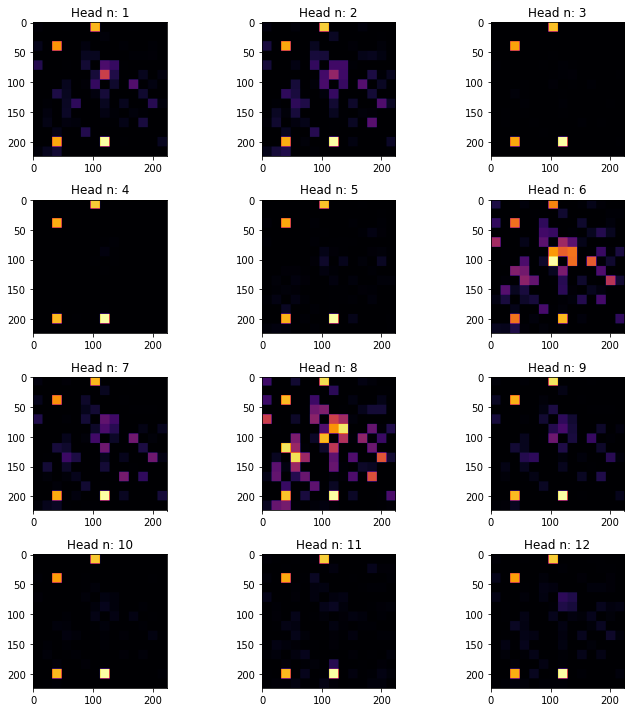

In [76]:
test_dir = '/kaggle/input/mva-recvis-2022/bird_dataset/test_images/mistery_category'
f = '1f5074135fcf27f86c32db0d76fa0453.jpg' # loaded image from the test set
img = pil_loader(test_dir + '/' + f)
img = img.resize((224,224))
output = predict_class(img, model_finetuned)
visualize_predict(output, img, img.size, patch_size=16)

# Finetuning the model with augmented data

In this section, we use data augmentation in order to regularize the classification head of the pretrained model. We will add some other transforms alongside the feature_extractor of the pretrained model. We will add some other transforms alongside the feature_extractor of the pretrained model. 

In [48]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    RandomRotation,
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [   RandomResizedCrop(feature_extractor.size),
            RandomRotation(20),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

Let's define another transform function which will consider the transforms above and not only the feature_extractor's

In [49]:
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [50]:
prepared_aug_train_dataset = train_dataset.with_transform(train_transforms)
prepared_aug_val_dataset = val_dataset.with_transform(val_transforms)

In [51]:
from transformers import ViTForImageClassification

labels = train_dataset.features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    output_attentions=True,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)} 
)

loading configuration file https://huggingface.co/google/vit-base-patch16-224-in21k/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/7bba26dd36a6ff9f6a9b19436dec361727bea03ec70fbfa82b70628109163eaa.92995a56e2eabab0c686015c4ad8275b4f9cbd858ed228f6a08936f2c31667e7
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "004.Groove_billed_Ani",
    "1": "009.Brewer_Blackbird",
    "10": "020.Yellow_breasted_Chat",
    "11": "021.Eastern_Towhee",
    "12": "023.Brandt_Cormorant",
    "13": "026.Bronzed_Cowbird",
    "14": "028.Brown_Creeper",
    "15": "029.American_Crow",
    "16": "030.Fish_Crow",
    "17": "031.Black_billed_Cuckoo",
    "18": "033.Yellow_billed_Cuckoo",
    "19": "034.Gray_crowned_Rosy_Finch",
    "2": "010.Red_winge

In [52]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./vit-base-birds",  
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    report_to='tensorboard',
    remove_unused_columns=False,
)

PyTorch: setting up devices


In [53]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_aug_train_dataset,
    eval_dataset=prepared_aug_val_dataset,
    tokenizer=feature_extractor,
)

In [54]:
train_results = trainer.train()
trainer.save_model()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1081
  Num Epochs = 4
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 20
  Gradient Accumulation steps = 1
  Total optimization steps = 220
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.790531,0.485437
2,No log,2.600729,0.786408
3,No log,2.479394,0.834951
4,No log,2.433812,0.844660


***** Running Evaluation *****
  Num examples = 103
  Batch size = 8
Saving model checkpoint to ./vit-base-birds/checkpoint-55
Configuration saved in ./vit-base-birds/checkpoint-55/config.json
Model weights saved in ./vit-base-birds/checkpoint-55/pytorch_model.bin
Feature extractor saved in ./vit-base-birds/checkpoint-55/preprocessor_config.json
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 103
  Batch size = 8
Saving model checkpoint to ./vit-base-birds/checkpoint-110
Configuration saved in ./vit-base-birds/checkpoint-110/config.json
Model weights saved in ./vit-base-birds/checkpoint-110/pytorch_model.bin
Feature extractor saved in ./vit-base-birds/checkpoint-110/preprocessor_config.json
/opt/conda/lib/python3.7/si

In [58]:
# import our fine-tuned model
fine_tuned_model_name_or_path = 'vit-base-birds'
model_finetuned = ViTForImageClassification.from_pretrained(fine_tuned_model_name_or_path)
# import features
feature_extractor_finetuned = ViTFeatureExtractor.from_pretrained(fine_tuned_model_name_or_path)

loading configuration file vit-base-birds/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "004.Groove_billed_Ani",
    "1": "009.Brewer_Blackbird",
    "2": "010.Red_winged_Blackbird",
    "3": "011.Rusty_Blackbird",
    "4": "012.Yellow_headed_Blackbird",
    "5": "013.Bobolink",
    "6": "014.Indigo_Bunting",
    "7": "015.Lazuli_Bunting",
    "8": "016.Painted_Bunting",
    "9": "019.Gray_Catbird",
    "10": "020.Yellow_breasted_Chat",
    "11": "021.Eastern_Towhee",
    "12": "023.Brandt_Cormorant",
    "13": "026.Bronzed_Cowbird",
    "14": "028.Brown_Creeper",
    "15": "029.American_Crow",
    "16": "030.Fish_Crow",
    "17": "031.Black_billed_Cuckoo",
    "18": "033.Yellow_billed_Cuckoo",
    "19": "034.Gray_crowned

In [61]:
predict_testset(model_finetuned, feature_extractor_finetuned)

100%|██████████| 517/517 [04:15<00:00,  2.02it/s]

Succesfully wrote kaggle.csv, you can upload this file to the kaggle competition website


### Credits

The model finetuning part of this work was inspired by the HuggingFace tutorial : https://huggingface.co/blog/fine-tune-vit